# Solar home: Model Predictive Control with Julia/JuMP

Pierre Haessig, May 2018

In [1]:
# Python-like string formatting:
using Formatting

# Optimization:
using JuMP
using Clp

# Plotting:
#using PyPlot
using Gadfly

## 1) Load problem data

### Solar home ratings

In [2]:
params = Dict(
    "E_rated" => 8., # kWh
    "P_grid_max" => 3., # kW, more than load
    "P_pvp" => 4.) # kW

Dict{String,Float64} with 3 entries:
  "E_rated"    => 8.0
  "P_pvp"      => 4.0
  "P_grid_max" => 3.0

### Load test data

TODO 2018-04-30: write a generic load_data function, like in Python and Matlab

In [16]:
d, header = readcsv("../../data/data_2011-2012.csv", header=true)

date = d[:,1]
d = d[:,2:end]
# Cast to Float64
d = Array{Float64}(d)

ndays = 30
nd_extra = 0
R1 = 7250 -1;           # Line 7250: 2011-11-29 00:00:00,0.52,0.0
R2 = R1 + (ndays+nd_extra)*48 - 1; # Line 8689: 2011-12-28 23:30:00,0.35,0.0

d = d[R1:R2, :]
date = date[R1:R2]
date[1], date[end]

("2011-11-29 00:00:00", "2011-12-28 23:30:00")

In [17]:
P_load = d[:,1];
# scaling of PV production
P_sun_1k = d[:,2]/1.04
P_sun = P_sun_1k*params["P_pvp"];

n = length(P_load)
n/48

30.0

time vectors

In [18]:
t = (0:(n-1))*0.5 # hours
td = t/24 # days
dt = 0.5 # hours

0.5

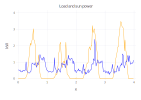

In [19]:
ndp = 4 # nb of days to plot
plot(layer(x=td[1:ndp*48], y=P_load[1:ndp*48], Geom.line, Theme(default_color=colorant"blue")  ),
     layer(x=td[1:ndp*48], y=P_sun[1:ndp*48],  Geom.line, Theme(default_color=colorant"orange") ),
    Guide.title("Load and sun power"), Guide.ylabel("kW")
)

#### Grid energy price

price function the of hour of the day

In [22]:
function grid_price(t)
    h = t .% 24 # in [0, 24[
    night = h .< 6
    day = .~ night
    c_grid = 0.10*night + 0.20*day
end

grid_price (generic function with 1 method)

In [25]:
c_grid = grid_price(t);

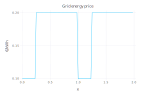

In [26]:
ndp = 2 # nb of days to plot
plot(x=td[1:ndp*48], y=c_grid[1:ndp*48], Geom.line,
     Guide.title("Grid energy price"), Guide.ylabel("€/kWh"))

Group time series in one Dict `data`

In [27]:
data = Dict(
    "t"        => collect(t),
    "P_load"   => P_load,
    "P_sun_1k" => P_sun_1k,
    "c_grid"   => c_grid,
)

Dict{String,Array{Float64,1}} with 4 entries:
  "P_sun_1k" => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0961538…
  "P_load"   => [0.52, 0.528, 0.496, 0.524, 0.418, 0.402, 0.434, 0.412, 0.508, …
  "t"        => [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  715.0, 71…
  "c_grid"   => [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.2, 0.2,…

### Load forecast data

In [28]:
cons_dpat, header = readcsv("../../data/daily_pattern_cons_M-1-2011-11-28.csv", header=true)

hod = cons_dpat[:,1];
cons_dmean = cons_dpat[:,2];

prod_dpat, header = readcsv("../../data/daily_pattern_prod_M-1-2011-11-28.csv", header=true)
prod_dmean = prod_dpat[:,2];
prod_dmean .*= params["P_pvp"]/1.04;

Repeat the daily pattern for each day of the test period

In [29]:
P_load_fc = repeat(cons_dmean, outer=ndays);
P_sun_fc = repeat(prod_dmean, outer=ndays);

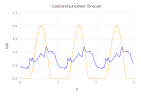

In [30]:
ndp = 3 # nb of days to plot
plot(layer(x=td[1:ndp*48], y=P_load_fc[1:ndp*48], Geom.line, Theme(default_color=colorant"blue")  ),
     layer(x=td[1:ndp*48], y=P_sun_fc[1:ndp*48],  Geom.line, Theme(default_color=colorant"orange") ),
     Guide.title("Load and sun power forecast"), Guide.ylabel("kW")
)

## 2) MPC control functions

In [ ]:
function control_mpc(params, dt, E_sto, P_load_fc, P_sun_fc, c_grid_fc)
    E_rated = params["E_rated"]
    P_grid_max = params["P_grid_max"]
    # TO BE CONTINUED
    
    P_sun = data["P_sun_1k"] * params["P_pvp"]
    P_load = data["P_load"]
    c_grid = data["c_grid"]
    dt = data["t"][2] - data["t"][1]
    
    n = length(P_load)
    
    m = Model(solver = ClpSolver())
    
    @variable(m, 0 <= E[1:n+1] <= E_rated)
    @variable(m, 0 <= P_grid[1:n] <= P_grid_max)
    @variable(m, P_curt[1:n] >= 0)
    @variable(m, P_sto[1:n])

    for k = 1:n
        @constraint(m, E[k+1] == E[k] + P_sto[k]*dt)
        @constraint(m, P_sun[k] - P_curt[k] + P_grid[k] == P_sto[k] + P_load[k])
        @constraint(m, P_curt[k] <= P_sun[k])
    end

    @constraint(m, E[1] == E[n+1]) # periodicity
    @constraint(m, E[1] == E_rated/2) # half-full startup
    
    if cost
        @objective(m, Min, sum(P_grid .* c_grid))
    else
        @objective(m, Min, sum(P_grid))
    end

    status = solve(m)
    status == :Optimal || error("Optimization status was not 'Optimal' but '$(status)'")
    
    # trajectories of all variables
    traj = Dict(
        "E_sto" => getvalue(E)[1:end-1], # state 
        "P_sto" => getvalue(P_sto), # out

        "P_load_sp" => P_load,
        "P_shed" => zeros(P_load),
        "P_load" => P_load,

        "P_sun"  => P_sun,
        "P_curt" => getvalue(P_curt),
        "P_pv"   => P_sun .- getvalue(P_curt),

        "P_grid" => getvalue(P_grid),
        "c_grid" => c_grid,
    )
    return traj
    return P_sto, P_grid, P_curt
end

**TODO**: try reusing the optimization model, with [constraints modification](http://www.juliaopt.org/JuMP.jl/0.18/probmod.html)

### Anticipative

battery schedule depends on the future data

In [13]:
function optim_anticip(params, data, cost=true)
    E_rated = params["E_rated"]
    P_grid_max = params["P_grid_max"]
    
    P_sun = data["P_sun_1k"] * params["P_pvp"]
    P_load = data["P_load"]
    c_grid = data["c_grid"]
    dt = data["t"][2] - data["t"][1]
    
    n = length(P_load)
    
    m = Model(solver = ClpSolver())
    
    @variable(m, 0 <= E[1:n+1] <= E_rated)
    @variable(m, 0 <= P_grid[1:n] <= P_grid_max)
    @variable(m, P_curt[1:n] >= 0)
    @variable(m, P_sto[1:n])

    for k = 1:n
        @constraint(m, E[k+1] == E[k] + P_sto[k]*dt)
        @constraint(m, P_sun[k] - P_curt[k] + P_grid[k] == P_sto[k] + P_load[k])
        @constraint(m, P_curt[k] <= P_sun[k])
    end

    @constraint(m, E[1] == E[n+1]) # periodicity
    @constraint(m, E[1] == E_rated/2) # half-full startup
    
    if cost
        @objective(m, Min, sum(P_grid .* c_grid))
    else
        @objective(m, Min, sum(P_grid))
    end

    status = solve(m)
    status == :Optimal || error("Optimization status was not 'Optimal' but '$(status)'")
    
    # trajectories of all variables
    traj = Dict(
        "E_sto" => getvalue(E)[1:end-1], # state 
        "P_sto" => getvalue(P_sto), # out

        "P_load_sp" => P_load,
        "P_shed" => zeros(P_load),
        "P_load" => P_load,

        "P_sun"  => P_sun,
        "P_curt" => getvalue(P_curt),
        "P_pv"   => P_sun .- getvalue(P_curt),

        "P_grid" => getvalue(P_grid),
        "c_grid" => c_grid,
    )
    return traj
end

optim_anticip (generic function with 2 methods)

### Fixed battery schedule

and then adjust recourse P_grid and P_curt

In [14]:
pos(x) = x>0 ? x : 0.

pos (generic function with 1 method)

In [15]:
function optim_fixed(params, data, P_sun_fc, P_load_fc)
    E_rated = params["E_rated"]
    P_grid_max = params["P_grid_max"]
    
    P_sun = data["P_sun_1k"] * params["P_pvp"]
    P_load = data["P_load"]
    c_grid = data["c_grid"]
    dt = data["t"][2] - data["t"][1]
    
    n = length(P_load)
    
    m = Model(solver = ClpSolver())

    @variable(m, 0 <= E[1:n+1] <= E_rated)
    @variable(m, 0 <= P_grid[1:n] <= P_grid_max)
    @variable(m, P_curt[1:n] >= 0)
    @variable(m, P_sto[1:n])

    for k = 1:n
        @constraint(m, E[k+1] == E[k] + P_sto[k]*dt)
        @constraint(m, P_sun_fc[k] - P_curt[k] + P_grid[k] == P_sto[k] + P_load_fc[k])
        @constraint(m, P_curt[k] <= P_sun_fc[k])
    end

    @constraint(m, E[1] == E[n+1]) # periodicity
    @constraint(m, E[1] == E_rated/2) # half-full startup

    @objective(m, Min, sum(P_grid .* c_grid))
    
    status = solve(m)
    status == :Optimal || error("Optimization status was not 'Optimal' but '$(status)'")
    
    # Recompute the recourse:
    P_sto = getvalue(P_sto)
    P_diff = P_sun - P_load .- P_sto
    P_curt = pos.(P_diff)
    P_grid = pos.(-P_diff)
    
    # trajectories of all variables
    traj = Dict(
        "E_sto" => getvalue(E)[1:end-1], # state 
        "P_sto" => P_sto, # out

        "P_load_sp" => P_load,
        "P_shed" => zeros(P_load),
        "P_load" => P_load,

        "P_sun"  => P_sun,
        "P_curt" => P_curt,
        "P_pv"   => P_sun .- P_curt,

        "P_grid" => P_grid,
        "c_grid" => c_grid,
    )
    return traj
end

optim_fixed (generic function with 1 method)

## 3) Run and compare optimizations

In [16]:
traj_anticip = optim_anticip(params, data, true)
traj_anticip_en = optim_anticip(params, data, false)
traj_fixed = optim_fixed(params, data, P_sun_fc, P_load_fc);

### Statistics over trajectories

warning about the computation of grid energy cost: the product of $P_{grid}$ (kW) and  $c_{grid}$ (€/kWh) is homogeneous to **€/h**. Therefore, daily cost is

$$mean(P_{grid} * c_{grid})*24$$

(no `dt` factor!)

In [17]:
function traj_stats(traj)
    s = Dict(
        "P_sto"     => mean(traj["P_sto"])*24,
        "P_load_sp" => mean(traj["P_load_sp"])*24,
        "P_shed"    => mean(traj["P_shed"])*24,
        "P_load"    => mean(traj["P_load"])*24,
        "P_sun"     => mean(traj["P_sun"])*24,
        "P_curt"    => mean(traj["P_curt"])*24,
        "P_pv"      => mean(traj["P_pv"])*24,
        "P_grid"    => mean(traj["P_grid"])*24,
        "C_grid"    => mean(traj["P_grid"] .* traj["c_grid"])*24,
    )
    return s
end

traj_stats (generic function with 1 method)

In [18]:
stats_anticip = traj_stats(traj_anticip)
stats_anticip_en = traj_stats(traj_anticip_en)
stats_fixed = traj_stats(traj_fixed);

stats_anticip

Dict{String,Float64} with 9 entries:
  "P_sun"     => 15.6041
  "P_pv"      => 13.639
  "P_sto"     => 0.0
  "P_load"    => 17.017
  "P_shed"    => 0.0
  "P_curt"    => 1.96509
  "P_load_sp" => 17.017
  "P_grid"    => 3.37802
  "C_grid"    => 0.353734

Pretty print of stats

In [19]:
function pprint_stats(s)
    printfmtln("P_load:    {:5.2f} kWh/d\n", s["P_load"])
    printfmtln("P_sun:     {:5.2f} kWh/d", s["P_sun"])
    printfmtln("P_curt:    {:5.2f} kWh/d", s["P_curt"])
    printfmtln("P_pv:      {:5.2f} kWh/d\n", s["P_pv"])
    printfmtln("P_sto:     {:5.2f} kWh/d\n", s["P_sto"])
    printfmtln("P_grid:    {:5.2f} kWh/d", s["P_grid"])
    printfmtln("C_grid:      {:.3f} €/d", s["C_grid"])

    return nothing
end

pprint_stats (generic function with 1 method)

In [20]:
pprint_stats(stats_anticip)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d
P_curt:     1.97 kWh/d
P_pv:      13.64 kWh/d

P_sto:      0.00 kWh/d

P_grid:     3.38 kWh/d
C_grid:      0.354 €/d


In [21]:
pprint_stats(stats_anticip_en)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d
P_curt:     1.97 kWh/d
P_pv:      13.64 kWh/d

P_sto:     -0.00 kWh/d

P_grid:     3.38 kWh/d
C_grid:      0.631 €/d


In [22]:
pprint_stats(stats_fixed)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d
P_curt:     5.32 kWh/d
P_pv:      10.28 kWh/d

P_sto:      0.00 kWh/d

P_grid:     6.74 kWh/d
C_grid:      1.016 €/d


#### Observations on performance statistics

* anticipative optimization: 0.177 €/d, with <P_grid> 3.38 kWh/d.

  * optimizing the grid energy instead of the cost yields the same energy!
  * Interpretation: cost optimization is performed only by *displacing the grid consumption*

* fixed: 0.508 €/d, with <P_grid> 6.74 kWh/d.

  * performance of this method is pretty bad!

* for reference, rule-based control yields 0.282 €/d, with <P_grid> 3.38 kWh/d

  * Interpretation: 3.38 kWh/d is a minimum which is easy to achieve
  * Minimizing the cost (with time-variying price) is however more difficult and some anticipation helps.

#### Quality check on grid cost computation

compation of average grid price, which should be between 0.10 and 0.20 €/kWh

In [25]:
0.631/3.38 # energy minimizing solution

0.18668639053254438

In [26]:
0.354/3.38 # cost minimizing solution

0.10473372781065088

Observation: the solution which minimizes the cost yields a average energy price **very close to the night price**.

### Save results in CSV file

In [27]:
function save_results(name, params, data, stats, traj)
    meta_fname = "results/$(name)_meta.csv"
    stat_fname = "results/$(name)_stat.csv"
    traj_fname = "results/$(name)_traj.csv"
    
    f = open(meta_fname, "w")
    println(f, "control method,E_rated,P_pvp")
    printfmtln(f, "{},{:.3f},{:.3f}", name, params["E_rated"], params["P_pvp"])
    close(f)
    
    f = open(stat_fname, "w")
    stat_order = [
        "P_sto",
        "P_load_sp","P_shed","P_load", # load
        "P_sun","P_curt","P_pv", # sun
        "P_grid","C_grid"]
    stat_header = join(stat_order, ",")
    println(f, stat_header)
    
    stat_mat = [stats[k] for k in stat_order]
    almost_0 = abs.(stat_mat) .<= 1e-13
    stat_mat[almost_0] = 0
    writecsv(f, stat_mat')
    close(f)
    
    f = open(traj_fname, "w")
    traj_header = ",E_sto,P_sto,P_load_sp,P_shed,P_load,P_sun,P_curt,P_pv,P_grid,c_grid"
    println(f, traj_header)
    
    traj_mat = hcat(data["t"],
      traj["E_sto"], traj["P_sto"], # storage
      traj["P_load_sp"], traj["P_shed"], traj["P_load"], # load
      traj["P_sun"], traj["P_curt"], traj["P_pv"], # sun
      traj["P_grid"], traj["c_grid"])
    writecsv(f, traj_mat)
    close(f)
    
    println("result files for method \"$(name)\" written!")
    return nothing
end

save_results (generic function with 1 method)

In [28]:
save_results("anticipative", params, data, stats_anticip, traj_anticip)

result files for method "anticipative" written!


In [29]:
save_results("anticipative-en", params, data, stats_anticip_en, traj_anticip_en)

result files for method "anticipative-en" written!


In [30]:
save_results("fixed", params, data, stats_fixed, traj_fixed)

result files for method "fixed" written!


### Plot trajectories

In [31]:
function plot_traj(traj, ndp)
    E_sto = traj["E_sto"]
    P_grid = traj["P_grid"]
    P_curt = traj["P_curt"];

    P_nl = traj["P_load"] - traj["P_sun"];
    P_gc = P_grid - P_curt;

    fig1a = plot(
        layer(x=td[1:ndp*48], y=P_nl[1:ndp*48], Geom.line, Theme(default_color=colorant"gray") ),
        layer(x=td[1:ndp*48], y=P_gc[1:ndp*48],  Geom.line, Theme(default_color=colorant"red") ) 
    )

    fig1b = plot(x=td[1:ndp*48], y=E_sto[1:ndp*48], Geom.line)
    fig1 = vstack(fig1a, fig1b)
end

plot_traj (generic function with 1 method)

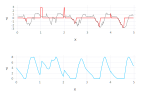

In [32]:
plot_traj(traj_anticip, 5)

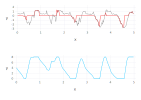

In [33]:
plot_traj(traj_anticip_en, 5)

Comparison of coumated grid energy, for anticipative optimization methods (cost vs. energy minimization)

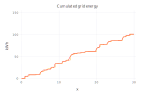

In [34]:
plot(layer(x=td, y=cumsum(traj_anticip_en["P_grid"])*dt, Geom.line, Theme(default_color=colorant"red")  ),
     layer(x=td, y=cumsum(traj_anticip["P_grid"])*dt,  Geom.line, Theme(default_color=colorant"orange") ),
     Guide.title("Cumulated grid energy"), Guide.ylabel("kWh")
)

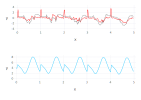

In [35]:
plot_traj(traj_fixed, 5)